In [25]:
import sys
import os

# Completely suppress stderr output
sys.stderr = open(os.devnull, 'w')

# Now import everything
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../../') # Make sure this is the location for the ART library

import warning_utils
warning_utils.filter_end_user_warnings()

In [26]:
import pandas as pd
import numpy as np

from art.core import RecommendationEngine
import art.utility as utils
import pickle
import cloudpickle
import matplotlib.pyplot as plt

In [27]:
print(np.__version__)

1.26.4


### Define directories

In [28]:
dataDir = '/code/DTRA_ART/DrugDesignData/'
modelBuildingDataDir = os.path.join(dataDir, 'modelBuildingData/')
resultsDir = os.path.join(dataDir, 'Results/')
artResultDir = resultsDir + 'ART_results/Ebola'
os.makedirs(artResultDir, exist_ok=True)

### Extract the data for `Ebola` into a data frame with `duplicate` SMILES

In [29]:
combinedEbolaVirusData_chEMBL_wMACAW = pd.read_csv(modelBuildingDataDir + "combinedEbolaVirusData_chEMBL_wMACAW.csv")
combinedEbolaVirusData_chEMBL_wMACAW 

,ID,compound_id,Smiles,pPotency,StrainClassifier,pPotency_category,MACAW_1,MACAW_2,MACAW_3,MACAW_4,...,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,1,CHEMBL3596788,COc1nc(N)ncc1-c1cn(COCCO)cn1,4.000000,Ebola,3-10,0.094141,-0.139420,0.124088,0.060349,...,0.026783,0.004198,-0.002835,0.019873,-0.001467,0.037200,0.031732,0.001404,-0.003453,0.004644
1,2,CHEMBL3753489,Nc1nccc2c1ncn2C1=C[C@@H](CO)[C@H](O)[C@@H]1O,6.494850,Ebola,3-10,0.088724,-0.231819,0.230660,0.344522,...,0.021663,0.091178,0.213487,-0.105224,0.041996,-0.138085,0.095778,-0.057034,-0.043537,0.065382
2,3,CHEMBL4751715,CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...,5.725842,Ebola,3-10,-0.104681,-0.018983,-0.069968,-0.059725,...,-0.024556,0.038969,0.018158,-0.000085,-0.047307,0.044088,-0.002265,0.065697,-0.058548,0.018335
3,4,CHEMBL4792617,CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...,5.603801,Ebola,3-10,-0.130472,-0.000989,-0.054204,-0.053824,...,-0.039563,0.046367,0.007336,0.009321,-0.089499,0.036521,-0.004912,0.053813,-0.051037,0.014743
4,5,CHEMBL5085366,CCCCCCCCCCCCCCCC(=O)O[C@H]1[C@@H](O)[C@](C#N)(...,4.301030,Ebola,3-10,-0.361188,0.009392,0.006950,-0.028253,...,-0.077350,0.057514,-0.015722,0.066771,-0.133440,0.043041,-0.118323,0.062600,-0.141848,0.156944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,857,CHEMBL5398314,O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21,6.283997,ZaireEbola,3-10,0.091436,0.005917,-0.086765,0.018041,...,-0.099534,0.074453,0.180142,0.004583,-0.005099,0.136826,0.035483,-0.102641,-0.039082,-0.093491
857,858,CHEMBL5398314,O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21,6.283997,ZaireEbola,3-10,0.091436,0.005917,-0.086765,0.018041,...,-0.099534,0.074453,0.180142,0.004583,-0.005099,0.136826,0.035483,-0.102641,-0.039082,-0.093491
858,859,CHEMBL5424177,O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1,5.721246,ZaireEbola,3-10,0.126847,-0.020899,-0.080507,0.012000,...,-0.183302,0.043778,0.210965,-0.071877,0.038515,0.228034,0.055007,-0.107080,-0.089125,-0.159999
859,860,CHEMBL5424177,O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1,5.721246,ZaireEbola,3-10,0.126847,-0.020899,-0.080507,0.012000,...,-0.183302,0.043778,0.210965,-0.071877,0.038515,0.228034,0.055007,-0.107080,-0.089125,-0.159999


### Prepare data to run `ART` on `Ebola` data with `duplicate` SMILES

Find Features and Response

In [30]:
input_var = [col for col in combinedEbolaVirusData_chEMBL_wMACAW.columns if col.startswith('MACAW_')]
print(f"MACAW Embeddings: {len(input_var)}")
print(input_var)

MACAW Embeddings: 15
['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15']


In [31]:
features = combinedEbolaVirusData_chEMBL_wMACAW[input_var].to_numpy()

In [32]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [33]:
response = combinedEbolaVirusData_chEMBL_wMACAW[response_var].to_numpy()

And then save the data as a EDD style file (see "Importing a Study" here):

In [34]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'combinedEbolaVirusData_chEMBL_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [35]:
combinedEbolaVirusData_chEMBL_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "combinedEbolaVirusData_chEMBL_wMACAW_ARTready.csv")
combinedEbolaVirusData_chEMBL_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,0.094141
1,1,MACAW_1,0.088724
2,2,MACAW_1,-0.104681
3,3,MACAW_1,-0.130472
4,4,MACAW_1,-0.361188
...,...,...,...
13771,856,pPotency,6.283997
13772,857,pPotency,6.283997
13773,858,pPotency,5.721246
13774,859,pPotency,5.721246


Let's now define the ART parameters needed for the prediction of production

In [36]:
art_params = {
    'input_vars': input_var,
    'response_vars': response_var,
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': 0.5,
    'num_recommendations': 10,
    'max_mcmc_cores': 4,
    'seed': 42,                    # Uncomment this to avoid a random seed
    'output_dir': artResultDir,
    'recommend': False,
    'cross_val': True,
    'num_tpot_models': 2,
}

And then run ART without recommendations but with cross-validations to gauge how generalizable the results are:

In [ ]:
%%time

art = RecommendationEngine(df=combinedEbolaVirusData_chEMBL_wMACAW_ARTready, **art_params)

ART identified 861 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See Data Preparation docs for a description of how ART infers design information. https://lbl-biosci.gitlab.io/ese/art/Data_Preparation/#labeling-lines-designs-replicates-oh-my


In [15]:
import shap
import matplotlib.pyplot as plt
import pickle 
import joblib
from joblib import load


import macaw
print(macaw.__version__)
from macaw import *

1.0.1


### Find SHAP values

We will now find which input features are more important by using SHAP analysis. First, lets initialize the library:

In [16]:
shap.initjs()

In [17]:
plt.style.use('default')

define a wrapper function that provides the ART prediction given and input X, for use by the SHAP library

In [18]:
def f(X):
    return art.predict(X)

convert the ART input data into the pandas dataframe that the SHAP library favors

In [19]:
X_df = pd.DataFrame(data=art.X, columns=art_params['input_vars'])

create and execute the explainer for the features values

In [20]:
explainer_e   = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)

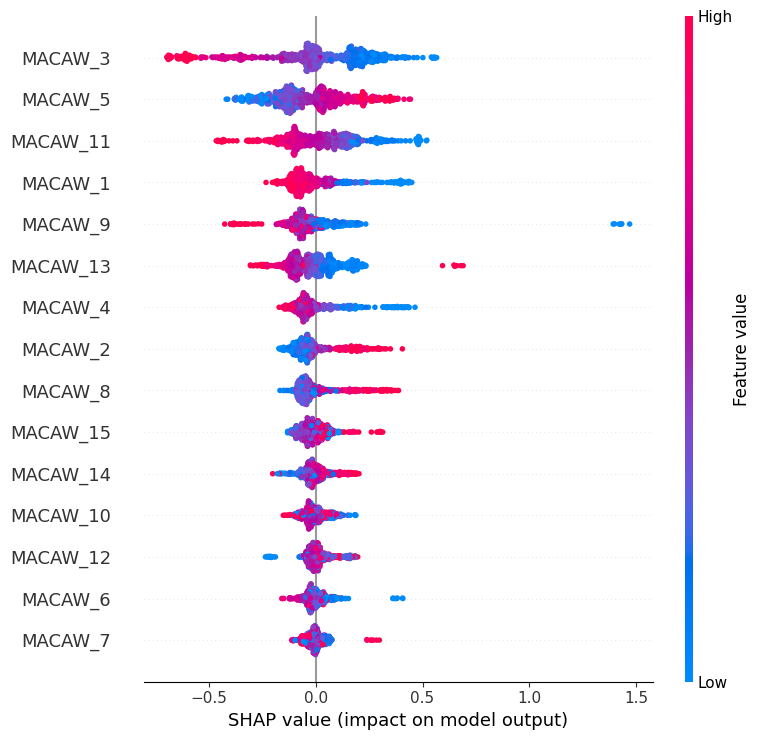

In [21]:
shap.summary_plot(shap_values_e)

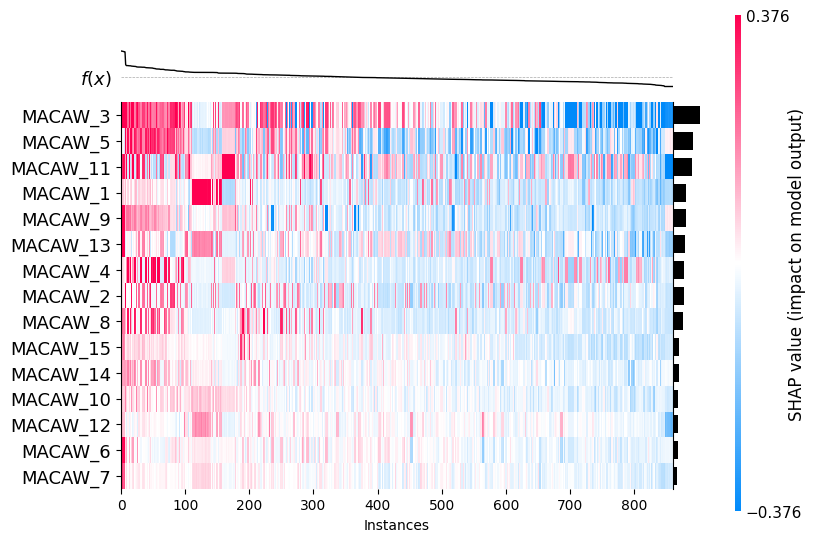

<Axes: xlabel='Instances'>

In [22]:
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=15)


## 2.1 Discovery of new hits specific to all viruses (data source Enamine_antiviralsData.csv)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [19]:
EnamineAntiviralsData = pd.read_csv(dataDir + "Enamine/Enamine_Antiviral_Library_plated_3200cmpds_20251019.csv",
                                    sep=",", comment=None, skipinitialspace=True, engine="python", encoding="utf-8",          
                                    skiprows=1, skip_blank_lines=True)
print(f"Original Enamine data shape: {EnamineAntiviralsData.shape}")

smiles_train = combinedEbolaVirusData_chEMBL_wMACAW.Smiles

# Function to canonicalize SMILES using RDKit
def canonicalize_smiles(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            return Chem.MolToSmiles(mol, canonical=True)
        else:
            return None
    except:
        return None

# Canonicalize training SMILES and create a set for fast lookup
canonical_train = set()
for smi in smiles_train:
    canonical_smi = canonicalize_smiles(smi)
    if canonical_smi is not None:
        canonical_train.add(canonical_smi)

print(f"Number of unique SMILES in training set: {len(canonical_train)}")

# Add canonical SMILES column to Enamine data
EnamineAntiviralsData['Canonical_SMILES'] = EnamineAntiviralsData['SMILES'].apply(canonicalize_smiles)

# Filter out duplicates - keep only those NOT in training set
mask = ~EnamineAntiviralsData['Canonical_SMILES'].isin(canonical_train)
EnamineAntiviralsData_filtered = EnamineAntiviralsData[mask].copy()

# Remove the helper column if you don't need it
EnamineAntiviralsData = EnamineAntiviralsData_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered Enamine data shape for validation: {EnamineAntiviralsData.shape}")
print(f"Removed {EnamineAntiviralsData.shape[0] - EnamineAntiviralsData_filtered.shape[0]} duplicate compounds from Enamine data set")

# Now use the filtered data
smi_lib = EnamineAntiviralsData.SMILES
print(f"Total compounds to screen: {len(smi_lib)}")
EnamineAntiviralsData.head()

Original Enamine data shape: (3200, 11)
Number of unique SMILES in training set: 0
Filtered Enamine data shape for validation: (3200, 11)
Removed 0 duplicate compounds from Enamine data set
Total compounds to screen: 3200


,SMILES,Catalog ID,MW,MW (desalted),ClogP,logS,HBD,HBA,TPSA,RotBonds,AnalogsFromREAL
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,Z410227912,256.326,256.326,1.231,-2.190,2,4,76.14,5,https://real.enamine.net/public-enum-files/Z41...
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,Z383167688,237.256,237.256,-0.042,-0.692,1,3,69.72,5,https://real.enamine.net/public-enum-files/Z38...
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,Z235579208,306.404,306.404,1.583,-2.082,1,5,57.70,7,NaN
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,Z403694008,279.379,279.379,1.156,-0.660,1,3,58.37,7,https://real.enamine.net/public-enum-files/Z40...
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,Z384461492,307.389,307.389,1.084,-1.180,1,4,61.88,7,https://real.enamine.net/public-enum-files/Z38...


Load pre-trained ART model

In [14]:
ARTtrainedModelFile = os.path.join(artResultDir, 'art.cpkl')
with open(ARTtrainedModelFile, 'rb') as f:
    regr_pred = cloudpickle.load(f)
print(f" ART model loaded from: {ARTtrainedModelFile}")

 ART model loaded from: /code/DTRA_ART/DrugDesignData/Results/ART_results/Ebola/art.cpkl


Load MACAW transformer

In [16]:
from joblib import load

macaw_file_path = os.path.join(modelBuildingDataDir, "combinedEbolaVirusData_chEMBL_MACAW_transformer.pkl")
mcw = load(macaw_file_path)
print(f" MACAW transformer loaded from: {macaw_file_path}")

 MACAW transformer loaded from: /code/DTRA_ART/DrugDesignData/modelBuildingData/combinedEbolaVirusData_chEMBL_MACAW_transformer.pkl


In [15]:
combinedEbolaVirus_EnamineDatasets_wMACAW = pd.read_csv(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_EnamineDatasets_wMACAW.csv")
combinedEbolaVirus_EnamineDatasets_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,0.082020,-0.100465,0.143736,0.012740,0.010961,0.034782,0.041563,-0.032900,-0.020971,-0.000958,0.031229,0.015966,0.041176,-0.002662,0.016790
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,0.110920,-0.062487,0.108433,0.032981,-0.039760,-0.000335,-0.009922,0.009645,0.010525,-0.055608,0.047151,-0.017454,-0.003200,0.042763,0.036375
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,0.135705,0.005716,0.107870,-0.023721,0.000330,-0.046364,-0.052455,-0.018845,0.032016,0.029700,0.073718,0.022457,0.004791,-0.003916,-0.002170
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,0.125130,-0.015689,0.147605,-0.044931,-0.013717,-0.020783,0.014473,0.011219,0.054396,0.018218,0.074911,0.040849,0.004347,0.019274,-0.003567
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,0.116205,0.003637,0.096678,-0.010097,-0.044401,-0.053487,-0.046328,-0.015374,0.020764,0.008956,0.042524,-0.004966,-0.068105,0.001894,0.041399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23,0.122703,-0.053339,0.078719,-0.026166,-0.026777,-0.013018,-0.007125,0.056246,0.053611,0.009724,0.016342,0.017610,0.036314,0.003301,-0.013848
3196,CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C,0.079400,-0.127978,0.121401,0.068619,0.005302,0.024694,-0.021394,-0.012761,-0.016283,-0.032004,0.004334,0.012093,0.006931,0.031921,0.003378
3197,CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O,0.093414,-0.027335,0.166525,-0.010139,-0.013965,-0.020281,-0.003219,-0.010655,0.024015,-0.021427,0.036737,0.035243,0.042036,0.014781,0.020752
3198,CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C,0.101787,-0.055251,0.125122,0.017768,0.018676,-0.030625,-0.038678,0.041798,0.064676,0.007268,0.019264,0.023452,0.001084,-0.000888,-0.011099


In [16]:
macaw_columns = [col for col in combinedEbolaVirus_EnamineDatasets_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_EnamineDatasets_wMACAW = combinedEbolaVirus_EnamineDatasets_wMACAW[macaw_columns].values
smi_lib_EnamineDatasets_wMACAW

array([[ 0.08201955, -0.10046457,  0.1437358 , ...,  0.04117564,
        -0.00266175,  0.0167902 ],
       [ 0.11091962, -0.06248719,  0.1084331 , ..., -0.00320049,
         0.04276346,  0.03637512],
       [ 0.13570527,  0.00571617,  0.10787032, ...,  0.00479122,
        -0.00391598, -0.00216985],
       ...,
       [ 0.093414  , -0.0273347 ,  0.1665247 , ...,  0.04203578,
         0.01478138,  0.02075247],
       [ 0.1017874 , -0.0552507 ,  0.12512175, ...,  0.00108423,
        -0.0008881 , -0.01109884],
       [ 0.08099229, -0.05945367,  0.12106498, ..., -0.03391925,
        -0.01809792,  0.02937274]])

In [17]:
%%time

#Y1_lib_pred = regr_pred.predict(X1_lib)
Y1_lib_pred = art.predict(smi_lib_EnamineDatasets_wMACAW)

CPU times: user 333 ms, sys: 109 ms, total: 442 ms
Wall time: 437 ms


Get predictions with uncertainty using ART's post_pred_stats

In [20]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_EnamineDatasets_wMACAW)

# Now use these for your results
EnamineAntiviralsData_predicted = EnamineAntiviralsData.copy()
EnamineAntiviralsData_predicted['pPotency_prediction'] = mean
EnamineAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
EnamineAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
EnamineAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
EnamineAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
EnamineAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_upper_95CI'])
EnamineAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
EnamineAntiviralsData_predicted = EnamineAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

EnamineAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_EnamineDatasets_predicted_all.csv"), index=False)
EnamineAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_EnamineDatasets_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
EnamineAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,4.650321,0.635944,3.403872,5.896770,0.000022,1.268322e-06,0.000395
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,4.900905,0.634928,3.656447,6.145364,0.000013,7.155439e-07,0.000221
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,4.793780,0.635491,3.548218,6.039342,0.000016,9.133928e-07,0.000283
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,4.779881,0.636283,3.532766,6.026997,0.000017,9.397306e-07,0.000293
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,5.171341,0.635297,3.926160,6.416522,0.000007,3.832460e-07,0.000119
...,...,...,...,...,...,...,...,...
3195,CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23,5.092861,0.635436,3.847406,6.338316,0.000008,4.588638e-07,0.000142
3196,CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C,4.953149,0.635248,3.708062,6.198235,0.000011,6.335261e-07,0.000196
3197,CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O,4.800541,0.635308,3.555337,6.045744,0.000016,9.000274e-07,0.000278
3198,CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C,5.118605,0.634811,3.874376,6.362835,0.000008,4.336756e-07,0.000134


Let us represent the predictions of both models

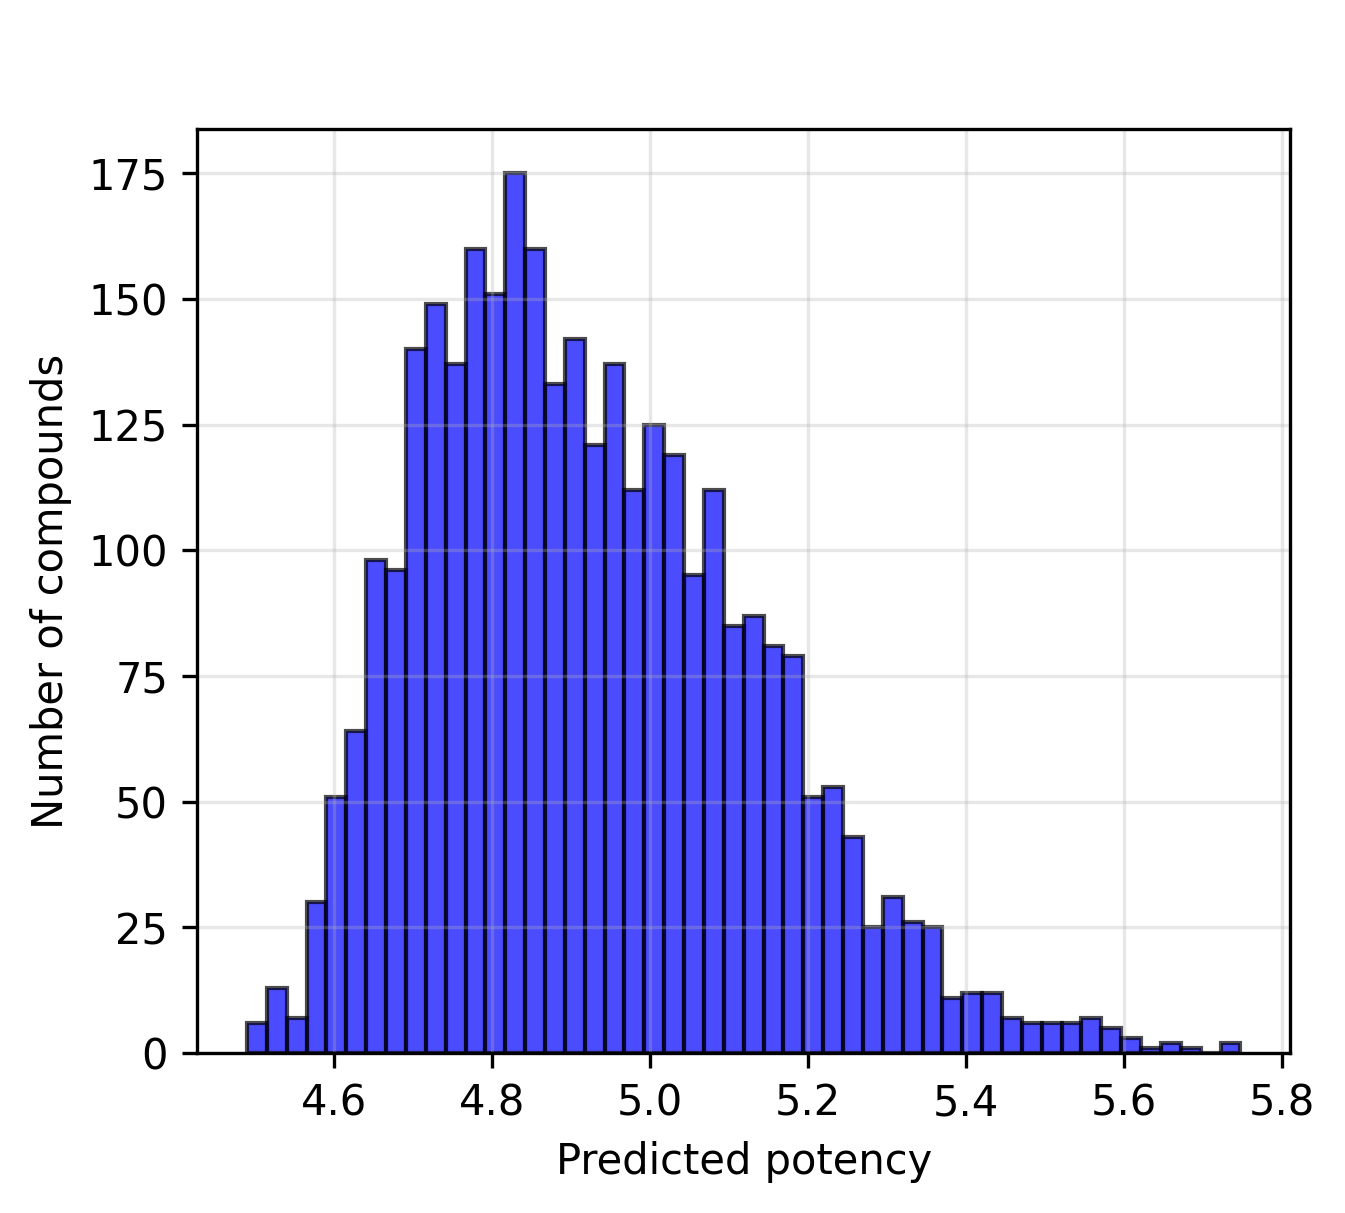

In [23]:
plt.figure(figsize=(4.7, 4.0), dpi=300)
plt.hist(Y1_lib_pred, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted potency")
plt.ylabel("Number of compounds")
#plt.axvline(x=5, color='r', linestyle='--', linewidth=2) # label='pPotency = 5.0 (minimum)'
#plt.axvline(x=6, color='g', linestyle='--', linewidth=2) # label='pPotency = 6.0 (good)'
#plt.axvline(x=7, color='b', linestyle='--', linewidth=2) # label='pPotency = 7.0 (excellent)'

# Legend on top, outside plot area
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

plt.grid(True, alpha=0.3)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_wART_validation.svg', bbox_inches='tight', dpi=300)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_wART_validation.png', bbox_inches='tight', dpi=300)
plt.show()

Let us have a look at the compounds:

In [24]:
# Define multiple priority levels
high_priority_idx = np.where(Y1_lib_pred >= 7.0)[0]
medium_priority_idx = np.where((Y1_lib_pred >= 6.0) & (Y1_lib_pred < 7.0))[0]
low_priority_idx = np.where((Y1_lib_pred >= 5.0) & (Y1_lib_pred < 6))[0]

print(f"High priority (pPotency ≥ 7.0): {len(high_priority_idx)} compounds")
print(f"Medium priority (6 ≤ pPotency < 7.0): {len(medium_priority_idx)} compounds")
print(f"Low priority (5 ≤ pPotency < 6): {len(low_priority_idx)} compounds")

# Use the one you need
idx = high_priority_idx  # or combine them

High priority (pPotency ≥ 7.0): 0 compounds
Medium priority (6 ≤ pPotency < 7.0): 0 compounds
Low priority (5 ≤ pPotency < 6): 1083 compounds


### Top 20 compounds with higher pPotency

In [ ]:
# Get indices of top 20 compounds sorted by predicted pPotency (highest to lowest)
Y1_lib_pred = Y1_lib_pred.flatten() 
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Get the cutoff pPotency (minimum value in top 20)
cutoff_pPotency = Y1_lib_pred[top_20_idx[-1]]  # Last (20th) value

print(f"Top 20 compounds cutoff pPotency: {cutoff_pPotency:.2f}")
print(f"Highest predicted pPotency: {Y1_lib_pred[top_20_idx[0]]:.2f}")
print(f"Range of top 20: {cutoff_pPotency:.2f} - {Y1_lib_pred[top_20_idx[0]]:.2f}")

In [ ]:
# Get top 20 indices by highest predicted pPotency
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Create dataframe with top 20
EnamineAntiviralsData_top20 = EnamineAntiviralsData.iloc[top_20_idx].copy()

# Add pPotency_prediction rounded to 3 decimal places
EnamineAntiviralsData_top20['pPotency_prediction'] = Y1_lib_pred[top_20_idx].round(3)

# Add IC50 column (convert pPotency to Molar units)
# IC50 (M) = 10^(-pPotency)
EnamineAntiviralsData_top20['IC50 (M)'] = 10**(-Y1_lib_pred[top_20_idx])

# Add rank column at the beginning
EnamineAntiviralsData_top20.insert(0, 'Rank', range(1, 21))

# Calculate ranges
pPotency_max = Y1_lib_pred[top_20_idx[0]]   # Highest (best)
pPotency_min = Y1_lib_pred[top_20_idx[-1]]  # Lowest (cutoff)
IC50_min = 10**(-pPotency_max)              # Lowest IC50 (most potent)
IC50_max = 10**(-pPotency_min)              # Highest IC50 (least potent in top 20)
IC50_min_nM = IC50_min * 1e9
IC50_max_nM = IC50_max * 1e9

# Display information
print("-"*70)
print("Top 20 Compounds with Highest Predicted pPotency")
print("-"*70)
print("\nCutoff Values (20th ranked compound):")
print(f"  pPotency:    {pPotency_min:.3f}")
print(f"  IC50:        {IC50_max:.3e} M  ({IC50_max_nM:.2f} nM)")

print("\nBest Values (1st ranked compound):")
print(f"  pPotency:    {pPotency_max:.3f}")
print(f"  IC50:        {IC50_min:.3e} M  ({IC50_min_nM:.2f} nM)")


print("Range for Top 20 Compounds:")
print(f"pPotency Range:  {pPotency_min:.3f} - {pPotency_max:.3f}")
print(f"\nIC50 Range (M):  {IC50_max:.3e} - {IC50_min:.3e}")
#print(f"IC50 Range (nM): {IC50_max_nM:.2f} - {IC50_min_nM:.2f} nM")
#print(f"                 (Δ = {pPotency_max - pPotency_min:.3f})")
#print(f"                 (Fold change = {IC50_max/IC50_min:.1f}x)")


# Set pandas display options for scientific notation
pd.options.display.float_format = lambda x: f'{x:.3e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.3f}'

# Display the dataframe
EnamineAntiviralsData_top20 = EnamineAntiviralsData_top20.filter(
    items=["Rank", "SMILES", "pPotency_prediction", "IC50 (M)"]
)
EnamineAntiviralsData_top20

In [ ]:
EnamineAntiviralsData_top20.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_EnamineAntiviralsData_top20.csv"), index=False)
EnamineAntiviralsData_top20[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_EnamineAntiviralsData_top20_SMILES.csv"), index=False)

## 2.2 Discovery of new hits specific to all viruses (data source Life chemicals data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [ ]:
# Read all molecules from SDF
supplier = Chem.SDMolSupplier(dataDir + "LifeChemicals/LC_Merged_Antiviral_Screening_Superset.sdf")
mols = [mol for mol in supplier if mol is not None]

# Extract properties into DataFrame
records = []
for mol in mols:
    props = mol.GetPropsAsDict()
    props["SMILES"] = Chem.MolToSmiles(mol)
    records.append(props)

LCAntiviralsData_superset = pd.DataFrame(records)
print(f"Original LifeChemicals data shape: {LCAntiviralsData_superset.shape}")

print(f"Number of unique SMILES in training set: {len(canonical_train)}")

# Add canonical SMILES column to LifeChemicals data (reusing canonical_train from code-1)
LCAntiviralsData_superset['Canonical_SMILES'] = LCAntiviralsData_superset['SMILES'].apply(canonicalize_smiles)

# Filter out duplicates - keep only those NOT in training set
mask = ~LCAntiviralsData_superset['Canonical_SMILES'].isin(canonical_train)
LCAntiviralsData_superset_filtered = LCAntiviralsData_superset[mask].copy()

# Remove the helper column if you don't need it
LCAntiviralsData_superset = LCAntiviralsData_superset_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered LifeChemicals data shape for validation: {LCAntiviralsData_superset.shape}")
print(f"Removed {LCAntiviralsData_superset_filtered.shape[0] - LCAntiviralsData_superset.shape[0]} duplicate compounds from LifeChemicals data set")

# Now use the filtered data
smi_lib = LCAntiviralsData_superset.SMILES
print(f"Total compounds to screen: {len(smi_lib)}")
LCAntiviralsData_superset.head()

Generate predictions for the H1 receptor:

In [ ]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = art.predict(X1_lib)

In [ ]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(X1_lib)

# Now use these for your results
LCAntiviralsData_predicted = LCAntiviralsData_superset.copy()
LCAntiviralsData_predicted['pPotency_prediction'] = mean
LCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
LCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
LCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
LCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
LCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_upper_95CI'])
LCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
LCAntiviralsData_predicted = LCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

LCAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_LCDatasets_predicted_all.csv"), index=False)
LCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_LCDatasets_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
LCAntiviralsData_predicted

Let us represent the predictions of both models:

In [ ]:
plt.figure(figsize=(4.7, 4.0), dpi=300)
plt.hist(Y1_lib_pred, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted potency")
plt.ylabel("Number of compounds")
#plt.axvline(x=5, color='r', linestyle='--', linewidth=2) # label='pPotency = 5.0 (minimum)'
#plt.axvline(x=6, color='g', linestyle='--', linewidth=2) # label='pPotency = 6.0 (good)'
#plt.axvline(x=7, color='b', linestyle='--', linewidth=2) # label='pPotency = 7.0 (excellent)'

# Legend on top, outside plot area
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

plt.grid(True, alpha=0.3)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_wART_validation_LCDatasets.svg', bbox_inches='tight', dpi=300)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_wART_validation_LCDatasets.png', bbox_inches='tight', dpi=300)
plt.show()

Let us have a look at the compounds:

In [ ]:
# Define multiple priority levels
high_priority_idx = np.where(Y1_lib_pred >= 7.0)[0]
medium_priority_idx = np.where((Y1_lib_pred >= 6.0) & (Y1_lib_pred < 7.0))[0]
low_priority_idx = np.where((Y1_lib_pred >= 5.0) & (Y1_lib_pred < 6))[0]

print(f"High priority (pPotency ≥ 7.0): {len(high_priority_idx)} compounds")
print(f"Medium priority (6 ≤ pPotency < 7.0): {len(medium_priority_idx)} compounds")
print(f"Low priority (5 ≤ pPotency < 6): {len(low_priority_idx)} compounds")

# Use the one you need
idx = high_priority_idx  # or combine them

In [ ]:
LCAntiviralsData_superset_final = LCAntiviralsData_superset.iloc[idx].copy()
LCAntiviralsData_superset_final['pPotency_prediction'] = Y1_lib_pred[idx]
LCAntiviralsData_superset_final = LCAntiviralsData_superset_final.filter(
    items=["SMILES", "pPotency_prediction", "clogP"]
)
LCAntiviralsData_superset_final

### Top 20 compounds with higher PpPotency

In [ ]:
# Get indices of top 20 compounds sorted by predicted pPotency (highest to lowest)
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Get the cutoff pPotency (minimum value in top 20)
cutoff_pPotency = Y1_lib_pred[top_20_idx[-1]]  # Last (20th) value

print(f"Top 20 compounds cutoff pPotency: {cutoff_pPotency:.2f}")
print(f"Highest predicted pPotency: {Y1_lib_pred[top_20_idx[0]]:.2f}")
print(f"Range of top 20: {cutoff_pPotency:.2f} - {Y1_lib_pred[top_20_idx[0]]:.2f}")

In [ ]:
# Get top 20 indices by highest predicted pPotency
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Create dataframe with top 20
LCAntiviralsData_top20 = LCAntiviralsData_superset.iloc[top_20_idx].copy()

# Add pPotency_prediction rounded to 3 decimal places
LCAntiviralsData_top20['pPotency_prediction'] = Y1_lib_pred[top_20_idx].round(3)

# Add IC50 column (convert pPotency to Molar units)
# IC50 (M) = 10^(-pPotency)
LCAntiviralsData_top20['IC50 (M)'] = 10**(-Y1_lib_pred[top_20_idx])

# Add rank column at the beginning
LCAntiviralsData_top20.insert(0, 'Rank', range(1, 21))

# Calculate ranges
pPotency_max = Y1_lib_pred[top_20_idx[0]]   # Highest (best)
pPotency_min = Y1_lib_pred[top_20_idx[-1]]  # Lowest (cutoff)
IC50_min = 10**(-pPotency_max)              # Lowest IC50 (most potent)
IC50_max = 10**(-pPotency_min)              # Highest IC50 (least potent in top 20)
IC50_min_nM = IC50_min * 1e9
IC50_max_nM = IC50_max * 1e9

# Display information
print("-"*70)
print("Top 20 Compounds with Highest Predicted pPotency")
print("-"*70)
print("\nCutoff Values (20th ranked compound):")
print(f"  pPotency:    {pPotency_min:.3f}")
print(f"  IC50:        {IC50_max:.3e} M  ({IC50_max_nM:.2f} nM)")

print("\nBest Values (1st ranked compound):")
print(f"  pPotency:    {pPotency_max:.3f}")
print(f"  IC50:        {IC50_min:.3e} M  ({IC50_min_nM:.2f} nM)")


print("Range for Top 20 Compounds:")
print(f"pPotency Range:  {pPotency_min:.3f} - {pPotency_max:.3f}")
print(f"\nIC50 Range (M):  {IC50_max:.3e} - {IC50_min:.3e}")
#print(f"IC50 Range (nM): {IC50_max_nM:.2f} - {IC50_min_nM:.2f} nM")
#print(f"                 (Δ = {pPotency_max - pPotency_min:.3f})")
#print(f"                 (Fold change = {IC50_max/IC50_min:.1f}x)")


# Set pandas display options for scientific notation
pd.options.display.float_format = lambda x: f'{x:.3e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.3f}'

# Display the dataframe
LCAntiviralsData_top20 = LCAntiviralsData_top20.filter(
    items=["Rank", "SMILES", "pPotency_prediction", "IC50 (M)"]
)
LCAntiviralsData_top20

In [ ]:
LCAntiviralsData_top20.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_LCAntiviralsData_top20.csv"), index=False)
LCAntiviralsData_top20[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_LCAntiviralsData_top20_SMILES.csv"), index=False)

## 2.3 Discovery of new hits specific to all viruses (data source `chemDiv` data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [ ]:
# Read all molecules from SDF
supplier = Chem.SDMolSupplier(dataDir + "ChemDiv/ChemDiv_Antiviral-Library-64958.sdf")
mols = [mol for mol in supplier if mol is not None]

# Extract properties into DataFrame
records = []
for mol in mols:
    props = mol.GetPropsAsDict()
    props["SMILES"] = Chem.MolToSmiles(mol)
    records.append(props)

ChemDivAntiviralsData = pd.DataFrame(records)
print(f"Original ChemDiv data shape: {ChemDivAntiviralsData.shape}")

print(f"Number of unique SMILES in training set: {len(canonical_train)}")

# Add canonical SMILES column to ChemDiv data (reusing canonical_train from previous code)
ChemDivAntiviralsData['Canonical_SMILES'] = ChemDivAntiviralsData['SMILES'].apply(canonicalize_smiles)

# Filter out duplicates - keep only those NOT in training set
mask = ~ChemDivAntiviralsData['Canonical_SMILES'].isin(canonical_train)
ChemDivAntiviralsData_filtered = ChemDivAntiviralsData[mask].copy()

# Remove the helper column if you don't need it
ChemDivAntiviralsData = ChemDivAntiviralsData_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered ChemDiv data shape for validation: {ChemDivAntiviralsData.shape}")
print(f"Removed {ChemDivAntiviralsData_filtered.shape[0] - ChemDivAntiviralsData.shape[0]} duplicate compounds from ChemDiv data set")

# Now use the filtered data
smi_lib = ChemDivAntiviralsData.SMILES
print(f"Total compounds to screen: {len(smi_lib)}")
ChemDivAntiviralsData

Generate predictions for the H1 receptor:

In [ ]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = art.predict(X1_lib)

In [ ]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(X1_lib)

# Now use these for your results
ChemDivAntiviralsData_predicted = ChemDivAntiviralsData.copy()
ChemDivAntiviralsData_predicted['pPotency_prediction'] = mean
ChemDivAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
ChemDivAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
ChemDivAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
ChemDivAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
ChemDivAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_upper_95CI'])
ChemDivAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
ChemDivAntiviralsData_predicted = ChemDivAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

ChemDivAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_ChemDivDatasets_predicted_all.csv"), index=False)
ChemDivAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_ChemDivDatasets_predicted_all_SMILES.csv"), index=False)
ChemDivAntiviralsData_predicted

Let us represent the predictions of both models:

In [ ]:
plt.figure(figsize=(4.7, 4.0), dpi=300)
plt.hist(Y1_lib_pred, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted potency")
plt.ylabel("Number of compounds")
#plt.axvline(x=5, color='r', linestyle='--', linewidth=2) # label='pPotency = 5.0 (minimum)'
#plt.axvline(x=6, color='g', linestyle='--', linewidth=2) # label='pPotency = 6.0 (good)'
#plt.axvline(x=7, color='b', linestyle='--', linewidth=2) # label='pPotency = 7.0 (excellent)'

# Legend on top, outside plot area
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

plt.grid(True, alpha=0.3)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_wART_validation_ChemDivDatasets.svg', bbox_inches='tight', dpi=300)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_wART_validation_ChemDivDatasets.png', bbox_inches='tight', dpi=300)
plt.show()

Let us have a look at the compounds:

In [ ]:
# Define multiple priority levels
high_priority_idx = np.where(Y1_lib_pred >= 7.0)[0]
medium_priority_idx = np.where((Y1_lib_pred >= 6.0) & (Y1_lib_pred < 7.0))[0]
low_priority_idx = np.where((Y1_lib_pred >= 5.0) & (Y1_lib_pred < 6))[0]

print(f"High priority (pPotency ≥ 7.0): {len(high_priority_idx)} compounds")
print(f"Medium priority (6 ≤ pPotency < 7.0): {len(medium_priority_idx)} compounds")
print(f"Low priority (5 ≤ pPotency < 6): {len(low_priority_idx)} compounds")

# Use the one you need
idx = high_priority_idx  # or combine them

In [ ]:
ChemDivAntiviralsData_final = ChemDivAntiviralsData.iloc[idx].copy()
ChemDivAntiviralsData_final['pPotency_prediction'] = Y1_lib_pred[idx]
ChemDivAntiviralsData_final = ChemDivAntiviralsData_final.filter(
    items=["SMILES", "pPotency_prediction", "clogP"]
)
ChemDivAntiviralsData_final

### Top 20 compounds with higher PpPotency

In [ ]:
# Get indices of top 20 compounds sorted by predicted pPotency (highest to lowest)
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Get the cutoff pPotency (minimum value in top 20)
cutoff_pPotency = Y1_lib_pred[top_20_idx[-1]]  # Last (20th) value

print(f"Top 20 compounds cutoff pPotency: {cutoff_pPotency:.2f}")
print(f"Highest predicted pPotency: {Y1_lib_pred[top_20_idx[0]]:.2f}")
print(f"Range of top 20: {cutoff_pPotency:.2f} - {Y1_lib_pred[top_20_idx[0]]:.2f}")

In [ ]:
# Get top 20 indices by highest predicted pPotency
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Create dataframe with top 20
ChemDivAntiviralsData_top20 = ChemDivAntiviralsData.iloc[top_20_idx].copy()

# Add pPotency_prediction rounded to 3 decimal places
ChemDivAntiviralsData_top20['pPotency_prediction'] = Y1_lib_pred[top_20_idx].round(3)

# Add IC50 column (convert pPotency to Molar units)
# IC50 (M) = 10^(-pPotency)
ChemDivAntiviralsData_top20['IC50 (M)'] = 10**(-Y1_lib_pred[top_20_idx])

# Add rank column at the beginning
ChemDivAntiviralsData_top20.insert(0, 'Rank', range(1, 21))

# Calculate ranges
pPotency_max = Y1_lib_pred[top_20_idx[0]]   # Highest (best)
pPotency_min = Y1_lib_pred[top_20_idx[-1]]  # Lowest (cutoff)
IC50_min = 10**(-pPotency_max)              # Lowest IC50 (most potent)
IC50_max = 10**(-pPotency_min)              # Highest IC50 (least potent in top 20)
IC50_min_nM = IC50_min * 1e9
IC50_max_nM = IC50_max * 1e9

# Display information
print("-"*70)
print("Top 20 Compounds with Highest Predicted pPotency")
print("-"*70)
print("\nCutoff Values (20th ranked compound):")
print(f"  pPotency:    {pPotency_min:.3f}")
print(f"  IC50:        {IC50_max:.3e} M  ({IC50_max_nM:.2f} nM)")

print("\nBest Values (1st ranked compound):")
print(f"  pPotency:    {pPotency_max:.3f}")
print(f"  IC50:        {IC50_min:.3e} M  ({IC50_min_nM:.2f} nM)")


print("Range for Top 20 Compounds:")
print(f"pPotency Range:  {pPotency_min:.3f} - {pPotency_max:.3f}")
print(f"\nIC50 Range (M):  {IC50_max:.3e} - {IC50_min:.3e}")
#print(f"IC50 Range (nM): {IC50_max_nM:.2f} - {IC50_min_nM:.2f} nM")
#print(f"                 (Δ = {pPotency_max - pPotency_min:.3f})")
#print(f"                 (Fold change = {IC50_max/IC50_min:.1f}x)")


# Set pandas display options for scientific notation
pd.options.display.float_format = lambda x: f'{x:.3e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.3f}'

# Display the dataframe
ChemDivAntiviralsData_top20 = ChemDivAntiviralsData_top20.filter(
    items=["Rank", "SMILES", "pPotency_prediction", "IC50 (M)"]
)
ChemDivAntiviralsData_top20

In [ ]:
ChemDivAntiviralsData_top20.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_ChemDivAntiviralsData_top20.csv"), index=False)
ChemDivAntiviralsData_top20[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_ChemDivAntiviralsData_top20_SMILES.csv"), index=False)

### 2.4 Discovery of new hits specific to all viruses (data source `SMACC` Antivirals data set)
In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models regr above, which use 15-D MACAW embeddings as their input. In particular, we are interested in molecules with high predicted pPotency.

In [ ]:
SMACCAntiviralsData = pd.read_csv(modelBuildingDataDir + "SMACCAntiviralsData_clean.csv")

# Check for duplicates
dup_check = SMACCAntiviralsData.groupby('SMILES')['pIC50'].agg(['count', 'median', 'std'])
duplicates = dup_check[dup_check['count'] > 1]
print(f"Original SMACC data shape: {SMACCAntiviralsData.shape}, with Duplicate SMILES: {len(duplicates)}")

# Take median pIC50 for duplicates
SMACCAntiviralsData = SMACCAntiviralsData.groupby('SMILES').agg({
    'Molecule ChEMBL ID': 'first',
    'pIC50': 'median',  # Use median instead of mean
    'Virus': 'first'
}).reset_index()

print(f"After removing internal duplicates: {SMACCAntiviralsData.shape}")

print(f"Number of unique SMILES in training set: {len(canonical_train)}")
# Add canonical SMILES column to SMACC data (reusing canonical_train from previous code)
SMACCAntiviralsData['Canonical_SMILES'] = SMACCAntiviralsData['SMILES'].apply(canonicalize_smiles)

# Filter out duplicates - keep only those NOT in training set
mask = ~SMACCAntiviralsData['Canonical_SMILES'].isin(canonical_train)
SMACCAntiviralsData_filtered = SMACCAntiviralsData[mask].copy()

# Remove the helper column if you don't need it
SMACCAntiviralsData = SMACCAntiviralsData_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered SMACC data shape for validation: {SMACCAntiviralsData.shape}")
print(f"Removed {SMACCAntiviralsData_filtered.shape[0] - SMACCAntiviralsData.shape[0]} duplicate compounds from SMACC data set")
SMACCAntiviralsData = SMACCAntiviralsData.rename(columns={'pIC50': 'pIC50_experimental'})

smi_lib = SMACCAntiviralsData.SMILES
print(f"Total compounds to screen: {len(smi_lib)}")
SMACCAntiviralsData.head()

Generate predictions

In [ ]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = art.predict(X1_lib)

In [ ]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(X1_lib)

# Now use these for your results
SMACCAntiviralsData_predicted = SMACCAntiviralsData.copy()
SMACCAntiviralsData_predicted['pPotency_prediction'] = mean
SMACCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
SMACCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
SMACCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
SMACCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
SMACCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_upper_95CI'])
SMACCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
SMACCAntiviralsData_predicted = SMACCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

SMACCAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_SMACCAntiviralsData_predicted_all.csv"), index=False)
SMACCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_SMACCAntiviralsData_predicted_all_SMILES.csv"), index=False)
SMACCAntiviralsData_predicted

### Plot the error between `experimental_pPotency` and `predicted_pPotency`

In [ ]:
# Calculate residuals (difference)
SMACCAntiviralsData_predicted['residuals'] = (
    SMACCAntiviralsData_predicted['pPotency_prediction'] - 
    SMACCAntiviralsData_predicted['pIC50_experimental']
)

# Print statistics
print(f"Mean Residual: {SMACCAntiviralsData_predicted['residuals'].mean():.3f}")
print(f"Std Dev of Residuals: {SMACCAntiviralsData_predicted['residuals'].std():.3f}")
print(f"Min Residual: {SMACCAntiviralsData_predicted['residuals'].min():.3f}")
print(f"Max Residual: {SMACCAntiviralsData_predicted['residuals'].max():.3f}")

# Create residual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Residuals vs Experimental values
axes[0].scatter(SMACCAntiviralsData_predicted['pIC50_experimental'], 
                SMACCAntiviralsData_predicted['residuals'], 
                alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_xlabel('Experimental pIC50', fontsize=12)
axes[0].set_ylabel('Residuals (Predicted - Experimental)', fontsize=12)
axes[0].set_title('Residual Plot', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution of residuals
axes[1].hist(SMACCAntiviralsData_predicted['residuals'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].axvline(x=SMACCAntiviralsData_predicted['residuals'].mean(), 
                color='blue', linestyle='--', linewidth=2, 
                label=f'Mean: {SMACCAntiviralsData_predicted["residuals"].mean():.3f}')
axes[1].set_xlabel('Residuals (Predicted - Experimental)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Residuals', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Residual Plot Analysis

In [ ]:
print(f"Mean residual: {SMACCAntiviralsData_predicted['residuals'].mean():.3f} (Close to 0 indicates no systematic bias)")
print(f"Std deviation: {SMACCAntiviralsData_predicted['residuals'].std():.3f} (typical prediction error)")
print(f"95% of predictions are within ±{1.96 * SMACCAntiviralsData_predicted['residuals'].std():.3f} pIC50 units")

### Plotting R2, MAE and RMSE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Extract
x = SMACCAntiviralsData_predicted['pIC50_experimental'].values
y = SMACCAntiviralsData_predicted['pPotency_prediction'].values

# Metrics
r2 = r2_score(x, y)
mae = mean_absolute_error(x, y)
mse = mean_squared_error(x, y)
rmse = mse ** 0.5


# Plot
plt.figure(figsize=(7, 6))
plt.scatter(x, y, alpha=0.4, color='blue', marker='o', s=50, 
           edgecolors='blue', linewidth=0.8)
plt.plot([min(x), max(x)], [min(x), max(x)], 'k--', linewidth=1.2)

plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.title("Experimental vs Predicted Potency")

# Metrics box
textstr = f"R² = {r2:.2f}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}"
plt.gca().text(
    0.05, 0.95, textstr, transform=plt.gca().transAxes,
    fontsize=10, verticalalignment='top',
    
)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

DF = SMACCAntiviralsData_predicted

x = DF['pIC50_experimental'].values
y = DF['pPotency_prediction'].values

# Metrics
r2 = r2_score(x, y)
mae = mean_absolute_error(x, y)
rmse = (mean_squared_error(x, y)) ** 0.5


plt.figure(figsize=(7, 6))

plt.scatter(range(len(x)), x, color='blue', alpha=0.7, label='pIC50 (Experimental)')
plt.scatter(range(len(y)), y, color='red', alpha=0.7, label='pIC50 (Predicted)')

plt.xlabel("Molecule Index")
plt.ylabel("Potency Values")
plt.title("Experimental (Blue) vs Predicted (Red) Potency")

plt.legend()
plt.tight_layout()
plt.show()


Let us have a look at the compounds:

In [ ]:
plt.figure(figsize=(4.7, 4.0), dpi=300)
plt.hist(Y1_lib_pred, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted potency")
plt.ylabel("Number of compounds")
#plt.title(f"Virtual screening of custom library ({len(smi_lib)} molecules)", pad=35)
#plt.axvline(x=5, color='r', linestyle='--', linewidth=2) # label='pPotency = 5.0 (minimum)'
#plt.axvline(x=6, color='g', linestyle='--', linewidth=2) # label='pPotency = 6.0 (good)'
#plt.axvline(x=7, color='b', linestyle='--', linewidth=2) # label='pPotency = 7.0 (excellent)'

# Legend on top, outside plot area
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

plt.grid(True, alpha=0.3)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_wART_validation_SMACCDatasets.svg', bbox_inches='tight', dpi=300)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_wART_validation_SMACCDatasets.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Define multiple priority levels
high_priority_idx = np.where(Y1_lib_pred >= 7)[0]
medium_priority_idx = np.where((Y1_lib_pred >= 6.0) & (Y1_lib_pred < 7.0))[0]
low_priority_idx = np.where((Y1_lib_pred >= 5.0) & (Y1_lib_pred < 6))[0]

print(f"High priority (pPotency ≥ 7.0): {len(high_priority_idx)} compounds")
print(f"Medium priority (6 ≤ pPotency < 7.0): {len(medium_priority_idx)} compounds")
print(f"Low priority (5 ≤ pPotency < 6): {len(low_priority_idx)} compounds")

# Use the one you need
idx = high_priority_idx  # or combine them

### Top 20 compounds with higher pPotency

In [ ]:
# Get indices of top 20 compounds sorted by predicted pPotency (highest to lowest)
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Get the cutoff pPotency (minimum value in top 20)
cutoff_pPotency = Y1_lib_pred[top_20_idx[-1]]  # Last (20th) value

print(f"Top 20 compounds cutoff pPotency: {cutoff_pPotency:.2f}")
print(f"Highest predicted pPotency: {Y1_lib_pred[top_20_idx[0]]:.2f}")
print(f"Range of top 20: {cutoff_pPotency:.2f} - {Y1_lib_pred[top_20_idx[0]]:.2f}")

In [ ]:
# Get top 20 indices by highest predicted pPotency
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Create dataframe with top 20
SMACCAntiviralsData_top20 = SMACCAntiviralsData_predicted.iloc[top_20_idx].copy()

# Add pPotency_prediction rounded to 3 decimal places
SMACCAntiviralsData_top20['pPotency_prediction'] = Y1_lib_pred[top_20_idx].round(3)

# Add IC50 column (convert pPotency to Molar units)
# IC50 (M) = 10^(-pPotency)
SMACCAntiviralsData_top20['IC50 (M)'] = 10**(-Y1_lib_pred[top_20_idx])

# Add rank column at the beginning
SMACCAntiviralsData_top20.insert(0, 'Rank', range(1, 21))

# Calculate ranges
pPotency_max = Y1_lib_pred[top_20_idx[0]]   # Highest (best)
pPotency_min = Y1_lib_pred[top_20_idx[-1]]  # Lowest (cutoff)
IC50_min = 10**(-pPotency_max)              # Lowest IC50 (most potent)
IC50_max = 10**(-pPotency_min)              # Highest IC50 (least potent in top 20)
IC50_min_nM = IC50_min * 1e9
IC50_max_nM = IC50_max * 1e9

# Display information
print("-"*70)
print("Top 20 Compounds with Highest Predicted pPotency")
print("-"*70)
print("\nCutoff Values (20th ranked compound):")
print(f"  pPotency:    {pPotency_min:.3f}")
print(f"  IC50:        {IC50_max:.3e} M  ({IC50_max_nM:.2f} nM)")

print("\nBest Values (1st ranked compound):")
print(f"  pPotency:    {pPotency_max:.3f}")
print(f"  IC50:        {IC50_min:.3e} M  ({IC50_min_nM:.2f} nM)")


print("Range for Top 20 Compounds:")
print(f"pPotency Range:  {pPotency_min:.3f} - {pPotency_max:.3f}")
print(f"\nIC50 Range (M):  {IC50_max:.3e} - {IC50_min:.3e}")
#print(f"IC50 Range (nM): {IC50_max_nM:.2f} - {IC50_min_nM:.2f} nM")
#print(f"                 (Δ = {pPotency_max - pPotency_min:.3f})")
#print(f"                 (Fold change = {IC50_max/IC50_min:.1f}x)")


# Set pandas display options for scientific notation
pd.options.display.float_format = lambda x: f'{x:.3e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.3f}'


SMACCAntiviralsData_top20

In [ ]:
SMACCAntiviralsData_top20.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_SMACCAntiviralsData_top20.csv"), index=False)
SMACCAntiviralsData_top20[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_SMACCAntiviralsData_top20_SMILES.csv"), index=False)

### Checking drug likeliness of `Remdesivir` and `Molnupiravir`

In [ ]:
Remdesivir_SMILES_file = os.path.join(dataDir + "/target_SMILES/Remdesivir_structure.mol")
Molnupiravir_SMILES_file = os.path.join(dataDir + "/target_SMILES/Molnupiravir_structure.mol")

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd

# SMILES strings
Remdesivir_SMILES = 'CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1'
Molnupiravir_SMILES = 'CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=C\C(NC1=O)=N\O'

# Dictionary of drugs and their SMILES
drugs = {
    'Remdesivir': Remdesivir_SMILES,
    'Molnupiravir': Molnupiravir_SMILES
}

# List to store results
smiles_data = []

# Process each drug
for drug_name, smiles in drugs.items():
    # Convert SMILES to molecule object
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is not None:
        smiles_data.append({
            'Drug_Name': drug_name,
            'SMILES': smiles,
            'Molecular_Formula': rdMolDescriptors.CalcMolFormula(mol),
            'Molecular_Weight': round(Descriptors.MolWt(mol), 2)
        })
        print(f" {drug_name}")
        print(f"  Formula: {rdMolDescriptors.CalcMolFormula(mol)}")
        print(f"  MW: {round(Descriptors.MolWt(mol), 2)} g/mol")
    else:
        print(f" Failed to parse SMILES for {drug_name}")

# Create DataFrame
DTRA_target_SMILES = pd.DataFrame(smiles_data)
DTRA_target_SMILES

In [ ]:
# Canonicalize training SMILES and create a set for fast lookup
canonical_train = set()
for smi in smiles_train:
    canonical_smi = canonicalize_smiles(smi)
    if canonical_smi is not None:
        canonical_train.add(canonical_smi)

print(f"Number of unique SMILES in training set: {len(canonical_train)}")

# Add canonical SMILES column to DTRA target data
DTRA_target_SMILES['Canonical_SMILES'] = DTRA_target_SMILES['SMILES'].apply(canonicalize_smiles)

# ADDED: Save original count BEFORE filtering
original_count = DTRA_target_SMILES.shape[0]

# Filter out duplicates - keep only those NOT in training set
mask = ~DTRA_target_SMILES['Canonical_SMILES'].isin(canonical_train)
DTRA_target_SMILES_filtered = DTRA_target_SMILES[mask].copy()

# Remove the helper column if you don't need it
DTRA_target_SMILES = DTRA_target_SMILES_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered DTRA target data shape for validation: {DTRA_target_SMILES.shape}")
print(f"Removed {original_count - DTRA_target_SMILES.shape[0]} duplicate compounds from DTRA target data set")  # FIXED

# Now use the filtered data
smi_lib = DTRA_target_SMILES.SMILES
print(f"Total DTRA target compounds to screen: {len(smi_lib)}")

# Display the filtered data
DTRA_target_SMILES

Generate predictions

In [ ]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = art.predict(X1_lib)

In [ ]:
DTRA_target_SMILES_predicted = DTRA_target_SMILES.copy()
DTRA_target_SMILES_predicted['pPotency_prediction'] = Y1_lib_pred

# Convert pPotency to IC50 (M)
# pPotency = -log10(IC50), so IC50 = 10^(-pPotency)
DTRA_target_SMILES_predicted['pPotency(M)_prediction'] = 10 ** (-DTRA_target_SMILES_predicted['pPotency_prediction'])

DTRA_target_SMILES_predicted = DTRA_target_SMILES_predicted.filter(
    items=["SMILES", "pPotency_prediction",  "pPotency(M)_prediction"]
)
DTRA_target_SMILES_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_wDuplicates_DTRAtargets_predicted_all.csv"), index=False)
DTRA_target_SMILES_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_wDuplicates_DTRAtargets_predicted_all_SMILES.csv"), index=False)
DTRA_target_SMILES_predicted

### Checking efficiency of `Remdesivir` as a antiviral, it present in training data set

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd

# SMILES strings
Remdesivir_SMILES = 'CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1'

# Dictionary of drugs and their SMILES
drugs = {
    'Remdesivir': Remdesivir_SMILES,
}

# List to store results
smiles_data = []

# Process each drug
for drug_name, smiles in drugs.items():
    # Convert SMILES to molecule object
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is not None:
        smiles_data.append({
            'Drug_Name': drug_name,
            'SMILES': smiles,
            'Molecular_Formula': rdMolDescriptors.CalcMolFormula(mol),
            'Molecular_Weight': round(Descriptors.MolWt(mol), 2)
        })
        print(f" {drug_name}")
        print(f"  Formula: {rdMolDescriptors.CalcMolFormula(mol)}")
        print(f"  MW: {round(Descriptors.MolWt(mol), 2)} g/mol")
    else:
        print(f" Failed to parse SMILES for {drug_name}")

# Create DataFrame
DTRA_target_SMILES = pd.DataFrame(smiles_data)
DTRA_target_SMILES

Find experimental pPotency value for `Remdesivir`

In [ ]:
# Function to canonicalize SMILES
def canonicalize_smiles(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        return Chem.MolToSmiles(mol, canonical=True) if mol else None
    except:
        return None

# Create mappings from allVirusData (without modifying it)
canonical_smiles = EbolaVirusData_chEMBL['Smiles'].apply(canonicalize_smiles)
smiles_to_pPotency = dict(zip(canonical_smiles, EbolaVirusData_chEMBL['pPotency']))
smiles_to_virus = dict(zip(canonical_smiles, EbolaVirusData_chEMBL['VirusClassifier']))

# Add columns to DTRA_target_SMILES
DTRA_target_SMILES['pIC50_experimental'] = DTRA_target_SMILES['SMILES'].apply(
    lambda x: smiles_to_pPotency.get(canonicalize_smiles(x), None)
)
DTRA_target_SMILES['VirusClassifier'] = DTRA_target_SMILES['SMILES'].apply(
    lambda x: smiles_to_virus.get(canonicalize_smiles(x), None)
)

# Display
print(f"Compounds with experimental data: {DTRA_target_SMILES['pIC50_experimental'].notna().sum()}")
DTRA_target_SMILES

In [ ]:
# Now use the filtered data
smi_lib = DTRA_target_SMILES.SMILES
print(f"Total DTRA target compounds to screen: {len(smi_lib)}")

Generate predictions

In [ ]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = art.predict(X1_lib)

In [ ]:
DTRA_target_SMILES_predicted = DTRA_target_SMILES.copy()
DTRA_target_SMILES_predicted['pPotency_prediction'] = Y1_lib_pred

# Convert pPotency to IC50 (M)
# pPotency = -log10(IC50), so IC50 = 10^(-pPotency)
DTRA_target_SMILES_predicted['IC50(M)_experimental'] = 10 ** (-DTRA_target_SMILES_predicted['pIC50_experimental'])
DTRA_target_SMILES_predicted['pPotency(M)_prediction'] = 10 ** (-DTRA_target_SMILES_predicted['pPotency_prediction'])

DTRA_target_SMILES_predicted = DTRA_target_SMILES_predicted.filter(
    items=["SMILES", "VirusClassifier", "pIC50_experimental", "pPotency_prediction",  "IC50(M)_experimental", "pPotency(M)_prediction"]
)
DTRA_target_SMILES_predicted

### Extract the data for `Ebola` into a data frame without `duplicate` SMILES

In [ ]:
EbolaVirusData_chEMBL_noDuplicates = pd.read_csv(modelBuildingDataDir + "EbolaVirusData_chEMBL_wMACAW_noDuplicates_MLready.csv")
EbolaVirusData_chEMBL_noDuplicates

### Prepare to run `ART` on `Ebola` data without `duplicate` SMILES